# Combinação de modelos - Parte 1

1) Esquema representativo da técnica de ensamble `Bagging`.

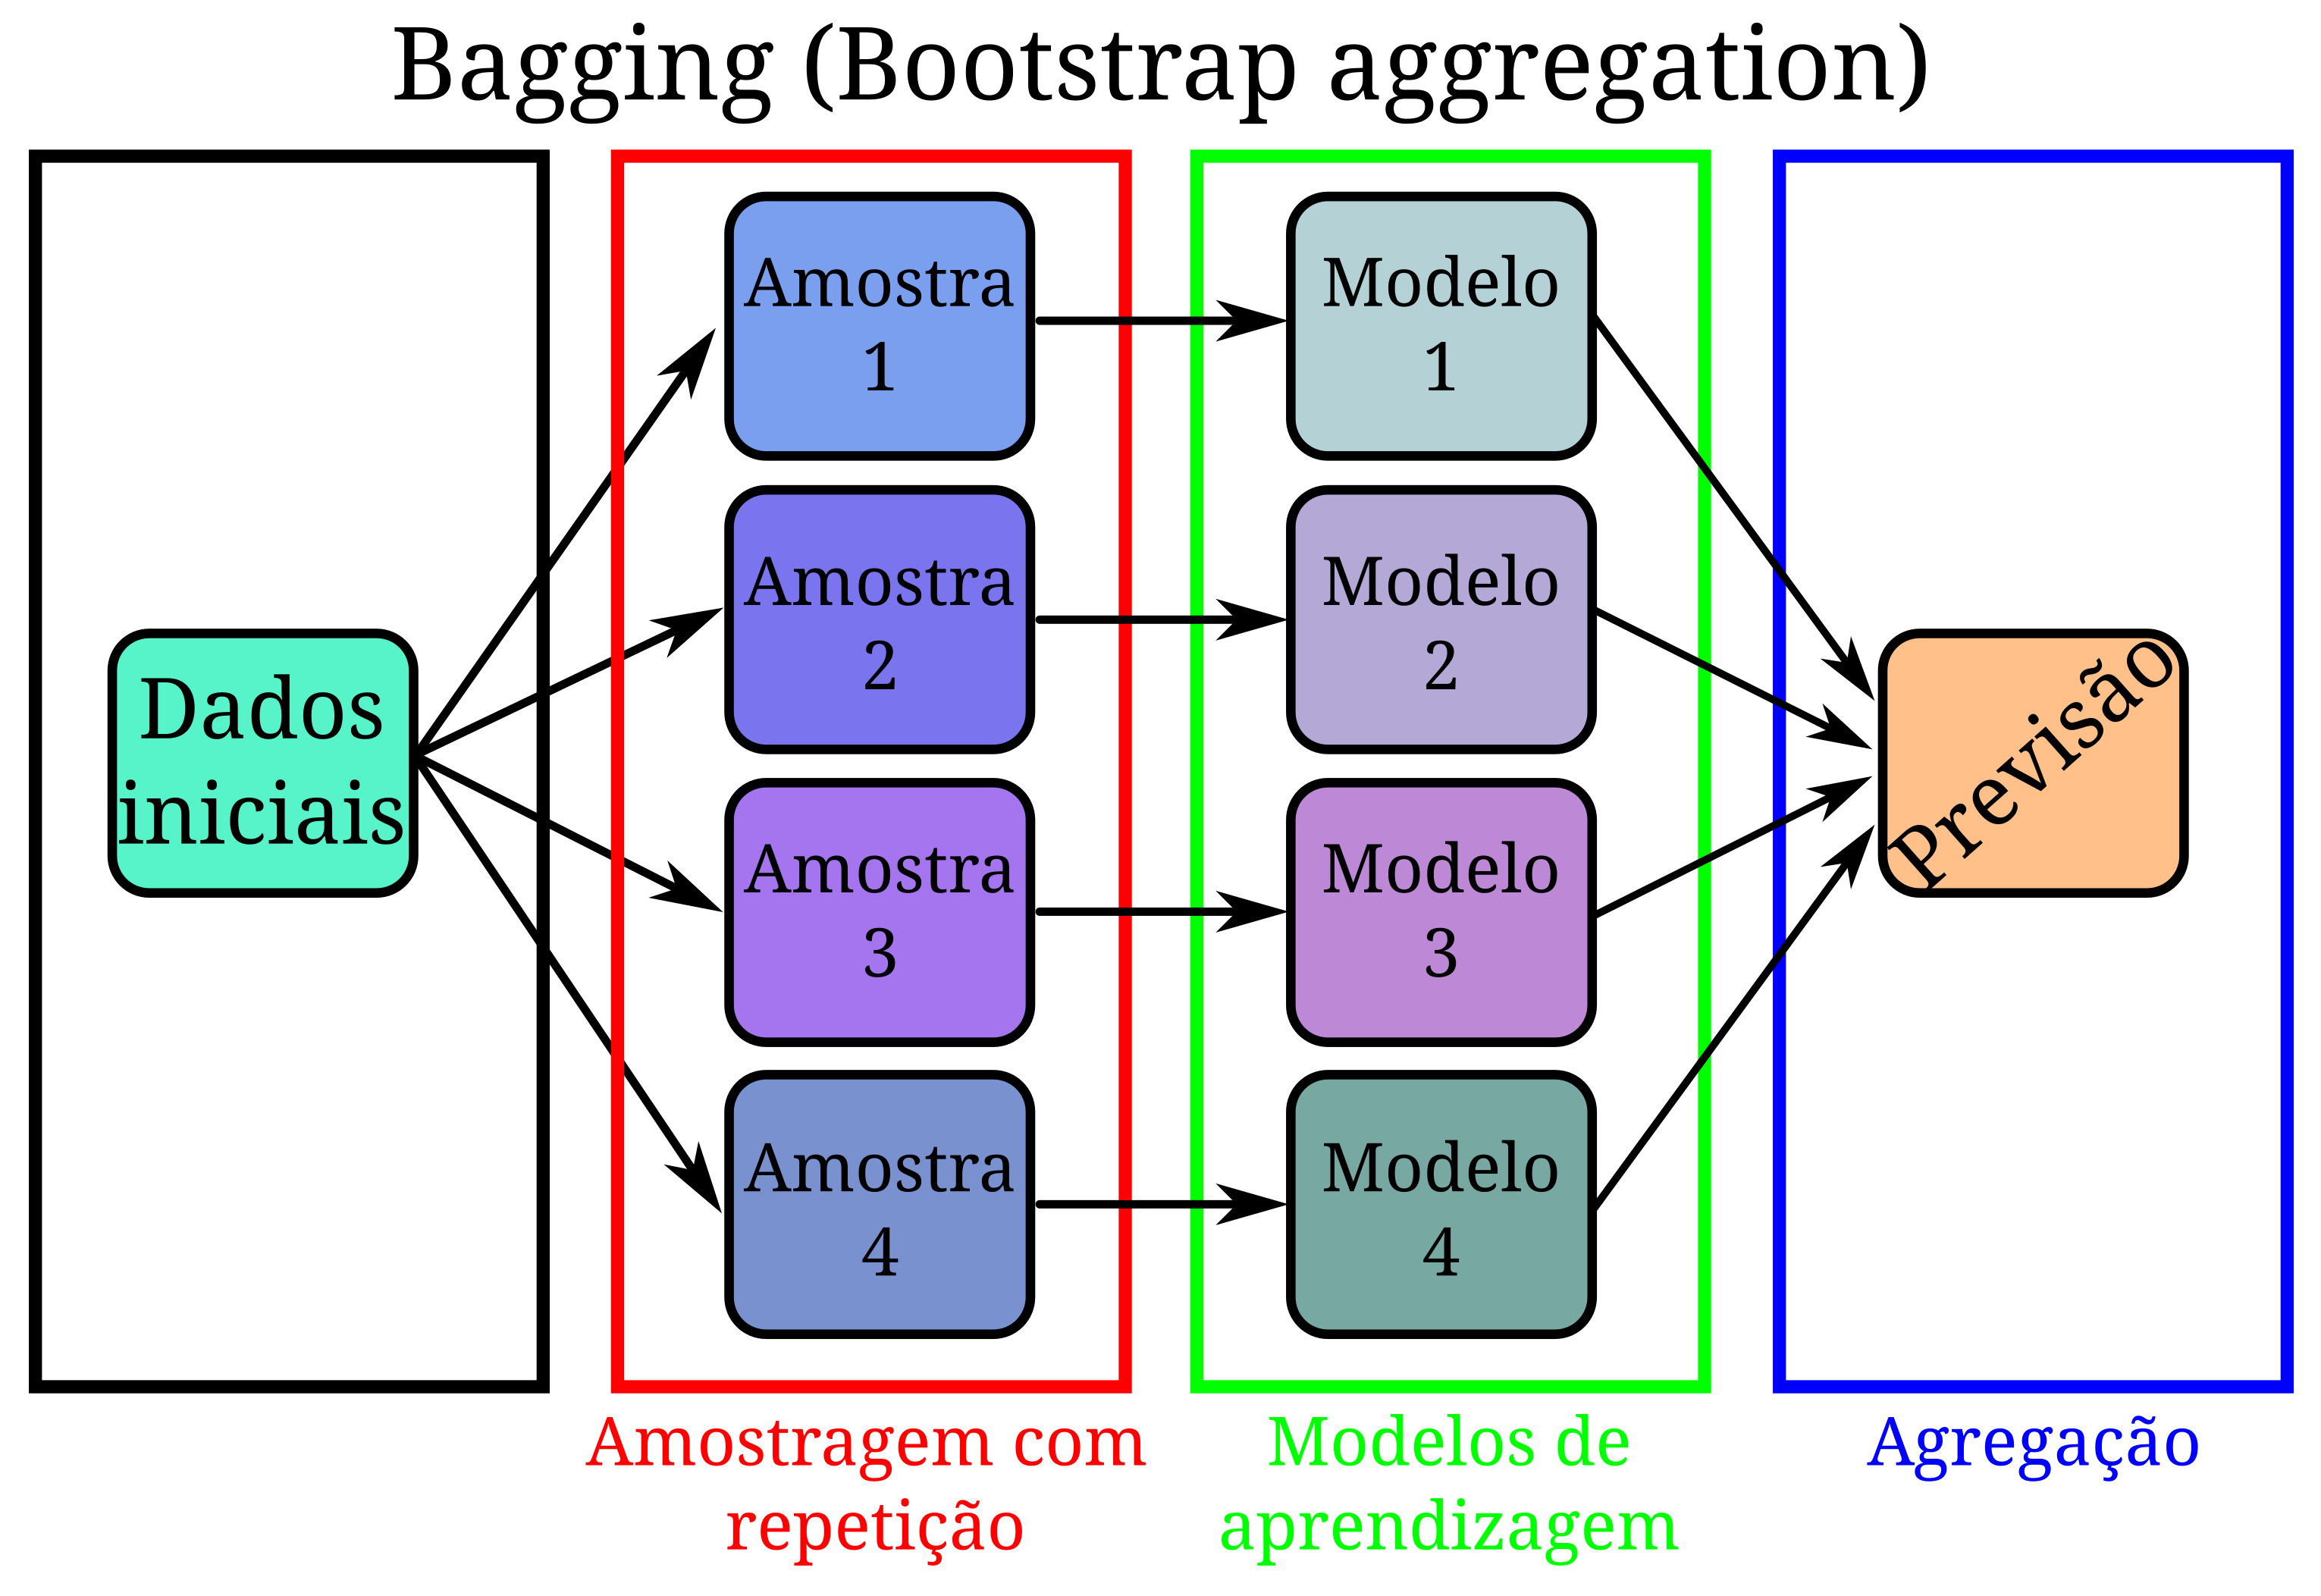


2) Entendimento da técnica:

A técnica de ensemble **Bagging** (bootstrap aggregation) é uma técnica de aprendizado que se concentra em ampliar a estabilidade de modelos de aprendizado de máquina. Esta se baseia em uma <span style='color: red'> amostragem com repetição</span> em que o conjunto de dados inicial é divido em amostras, nas quais parte dos dados podem ser repetidos. E etapa seguinte está associada ao desenvolvimento de <span style='color: green'> modelos de aprendizagem</span> que serão alimentados pelas amostras (cada modelo recebe uma amostra) e, por final, o resultado, a saída, desses modelos passa por um processo de <span style='color:blue'> agregação</span> no qual se tem a seleção da previsão. Para modelos de classificação, a seleção é escolhida com base na saída que mais se repete. Entretanto, para modelos de regressão, uma média dos valores de saída define a previsão.

3. Implementação em Python da técnica Bagging.

In [67]:
# bibliotecas 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from collections import Counter

import random

## Definindo a função Bagging

Destacando que a função `Bagging()` possui os parâmetros:
- df --> DataFrame
- decision_model --> 'classifier' para modelo de classificação e 'regressor' para modelo de regressão
- samples --> `int`, número de amostras (amostragem com repetição)
- sample_size --> padrão `None`, define o tamanho da amostra em dimensão
- target_var --> padrão `None`, define a variável de interesse (variável resposta)


A função irá retornar: 
- Os valores previstos pelos modelos
- Os valores de previsão selecionados pelo modelo `Bagging`

In [70]:
def Bagging(df, decision_model='classifier', samples=5, sample_size= None, target_var=None):

    if decision_model == 'classifier':
        decision_model_selected = DecisionTreeClassifier
    elif decision_model == 'regressor':
        decision_model_selected = DecisionTreeRegressor
    
    # Valores previstos
    valores_previstos = {}
    
    # Removendo os dados missing da variável de interesse (a serem previstos)
    df_treated = df[~df[target_var].isna()]

    # Amostras
    n_amostras = []
    for j, _ in enumerate(np.zeros(samples)):
        n_amostras.append(df_treated.sample(sample_size, replace=True))

    # Avaliando a quantidade de dados duplicados     
    for i, _ in enumerate(n_amostras):
        print('A quantidade de dados repetidos para a amostra {} é: '.format(i+1), _.duplicated().sum())
    print('############################################################\n')

    for i, amostra in enumerate(n_amostras):
        # Separando os dados em explicativos e target
        y = amostra[target_var]
        x = pd.get_dummies(amostra.drop(columns=[target_var]), drop_first=False)
        
        # Treino e teste
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.75, test_size=.25, random_state=100)
        
        # gerando árvore
        clf = decision_model_selected(random_state=100)
        path = clf.cost_complexity_pruning_path(x_train, y_train)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities
        
        # Usando pós-poda
        clfs = []
        for ccp_alpha in ccp_alphas:
            clf = decision_model_selected(ccp_alpha=ccp_alpha, random_state=100)
            clf.fit(x_train, y_train)
            clfs.append(clf)

        # Verificando "pontuação" dos modelos
        train_score = [clf.score(x_train, y_train) for clf in clfs]
        test_score = [clf.score(x_test, y_test) for clf in clfs]
    
        # Selecionando o melhor índice e a melhor árvore
        indice_melhor_arvore = len(test_score) - test_score[::-1].index(max(test_score)) - 1
        print('--> Modelo {}'.format(i+1))
        print('--> Melhor índice:', indice_melhor_arvore)
        melhor_arvore = clfs[indice_melhor_arvore]
        print('--> Melhor árvore:',melhor_arvore)
        print('--> Score melhor árvore {}%'.format(melhor_arvore.score(x_test, y_test)*100))
        
        # Definindo os valores a serem substituídos (previstos)
        prever = pd.get_dummies(df.drop(columns=[target_var]), drop_first=False)
        prever_target = prever[df[target_var].isna()]
        
        # Fazendo a classificação conforme a árvore
        predicted_values = melhor_arvore.predict(prever_target)
        print('--> Valores preditos pelo modelo {}: {}'.format(i+1, predicted_values))
        print('--------------------------------------------------------------------\n')

        # Dicionário com os dados a serem substituídos

        valor = {'Modelo {}'.format(i+1): predicted_values}
        valores_previstos.update(valor)


    # Oganizando dados previstos em listas
    lista = []
    list_returned_model = list(valores_previstos.values())
    n_elements_list_returned_model = list(valores_previstos.values())[0]    
    for k in range(len(n_elements_list_returned_model)): 
        inner_list = []
        lista.append(inner_list)
        for l in range(len(list_returned_model)):
            line = list(valores_previstos.values())[l][k]
            inner_list.append(line)
    # print(lista)

    
    # Gerando saída final do bagging
    if decision_model == 'classifier':
        aggregation_values = []
        for _ in lista:
            contador = dict(Counter(_))
            selector = dict(sorted(contador.items()))
            lista_first_item = list(selector)[0]
            aggregation_values.append(lista_first_item) 
        aggregation_values
        
    elif decision_model == 'regressor':
        lista_avg = []
        for _ in lista:
            # print(_)
            avg = sum(_)/len(_)
            lista_avg.append(avg)
            # print(avg)
        lista_avg    
        aggregation_values = lista_avg 

    return valores_previstos, aggregation_values


# Função para retornar dataframe com os dados previstos adicionados
def imput_bagging_values(df, target_var=None, aggregation_output=None):
    df.loc[df[target_var].isna(), target_var] = aggregation_output
    return df

### Carregando dados para verificação da função em relação ao parâmetro `decision_model='classifier`

Para tal, iremos carregar os dados "penguins" da biblioteca `seaborn`.

In [72]:
# Os dados
penguins = sns.load_dataset('penguins')
print(penguins.shape)
penguins.head()

(344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [73]:
# Dados faltantes
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [74]:
# Os dados faltantes

penguins[penguins['sex'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


In [75]:
penguins[penguins['bill_depth_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Sendo que a variáveil `bill_depth_mm` é um dado faltante, removendo tal variável pode-se notar que também removeremos as demais variáveis númericas faltantes.

In [77]:
penguins = penguins[~penguins['bill_depth_mm'].isna()].copy()
print(penguins.shape)
penguins.isna().sum()

(342, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

**Dados de "sex" que serão preenchidos pelo modelo**

In [79]:
penguins[penguins['sex'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


##### Aplicando a função `Bagging` 

- decision_model = 'classifier' (variável categórica)
- target_var = 'sex'

`Bagging(df, decision_model='classifier', samples=5, sample_size= None, target_var=None)`

> Para este caso é interessante selecionar um número ímpar de `samples` para evitar conflitos caso tenhamos contagens iguais para as saídas.

In [81]:
# Os prints apresentarão informações da função
# as variáveis irão armazenar apenas os valores de interesse

previsto, aggregation_values = Bagging(df=penguins, decision_model='classifier', samples=5, sample_size= 200, target_var='sex')

A quantidade de dados repetidos para a amostra 1 é:  57
A quantidade de dados repetidos para a amostra 2 é:  52
A quantidade de dados repetidos para a amostra 3 é:  55
A quantidade de dados repetidos para a amostra 4 é:  52
A quantidade de dados repetidos para a amostra 5 é:  50
############################################################

--> Modelo 1
--> Melhor índice: 1
--> Melhor árvore: DecisionTreeClassifier(ccp_alpha=0.006000000000000002, random_state=100)
--> Score melhor árvore 98.0%
--> Valores preditos pelo modelo 1: ['Female' 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Male']
--------------------------------------------------------------------

--> Modelo 2
--> Melhor índice: 4
--> Melhor árvore: DecisionTreeClassifier(ccp_alpha=0.024309823431860306, random_state=100)
--> Score melhor árvore 90.0%
--> Valores preditos pelo modelo 2: ['Female' 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Male']
--------------------------------------------

In [82]:
# Dados extraídos da função

print(previsto)
aggregation_values

{'Modelo 1': array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Male'], dtype=object), 'Modelo 2': array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Male'], dtype=object), 'Modelo 3': array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Male'], dtype=object), 'Modelo 4': array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female'], dtype=object), 'Modelo 5': array(['Female', 'Male', 'Female', 'Male', 'Female', 'Female', 'Female',
       'Female', 'Male'], dtype=object)}


['Female',
 'Male',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female',
 'Female']

In [83]:
# DataFrame dos dados
df_previsto = pd.DataFrame(previsto)
df_previsto['bagging aggregation values'] = pd.DataFrame(aggregation_values)
df_previsto

,Modelo 1,Modelo 2,Modelo 3,Modelo 4,Modelo 5,bagging aggregation values
0,Female,Female,Female,Female,Female,Female
1,Male,Male,Male,Male,Male,Male
2,Female,Female,Female,Female,Female,Female
3,Female,Female,Female,Female,Male,Female
4,Female,Female,Female,Female,Female,Female
5,Female,Female,Female,Female,Female,Female
6,Female,Female,Female,Female,Female,Female
7,Female,Female,Female,Female,Female,Female
8,Male,Male,Male,Female,Male,Female


In [84]:
# Dataframe completo
df_penguins_full = imput_bagging_values(df=penguins, target_var='sex', aggregation_output=aggregation_values)

In [85]:
df_penguins_full.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### Carregando dados para verificação da função em relação ao parâmetro `decision_model='regressor` 

Para isso vamos carregar o banco de dados do `seaborn` "tips" e adicionar alguns dados faltantes à coluna "tip".

In [87]:
# Carregando banco de dados tip

tips = sns.load_dataset('tips')
print(tips.shape)
print(tips.isna().sum())
tips.head()

(244, 7)
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [88]:
# Adicionando valores faltantes à tip

index_random = random.sample(range(0, len(tips)), 10)
print(index_random)
for _ in index_random:
    tips.loc[_, 'tip'] = np.NaN

# Agora temos 
tips.isna().sum()

[195, 6, 70, 29, 34, 242, 74, 114, 166, 111]


total_bill     0
tip           10
sex            0
smoker         0
day            0
time           0
size           0
dtype: int64

##### Aplicando a função `Bagging` 

- decision_model = 'regressor' (variável numérica)
- target_var = 'tip'

`Bagging(df, decision_model='classifier', samples=5, sample_size= None, target_var=None)`

In [90]:
previsto, aggregation_values = Bagging(df=tips, decision_model='regressor', samples=5, sample_size=200, target_var='tip')

A quantidade de dados repetidos para a amostra 1 é:  70
A quantidade de dados repetidos para a amostra 2 é:  64
A quantidade de dados repetidos para a amostra 3 é:  66
A quantidade de dados repetidos para a amostra 4 é:  74
A quantidade de dados repetidos para a amostra 5 é:  60
############################################################

--> Modelo 1
--> Melhor índice: 71
--> Melhor árvore: DecisionTreeRegressor(ccp_alpha=0.07063154334501771, random_state=100)
--> Score melhor árvore 49.939714262748524%
--> Valores preditos pelo modelo 1: [2.26193548 2.26193548 2.26193548 2.26193548 2.26193548 2.26193548
 3.31821429 3.31821429 2.26193548 2.26193548]
--------------------------------------------------------------------

--> Modelo 2
--> Melhor índice: 63
--> Melhor árvore: DecisionTreeRegressor(ccp_alpha=0.011712799999999817, random_state=100)
--> Score melhor árvore 50.75597549249742%
--> Valores preditos pelo modelo 2: [1.615      3.15783784 3.15783784 2.1764     3.32142857 1.4944444

In [91]:
print(previsto)
aggregation_values

{'Modelo 1': array([2.26193548, 2.26193548, 2.26193548, 2.26193548, 2.26193548,
       2.26193548, 3.31821429, 3.31821429, 2.26193548, 2.26193548]), 'Modelo 2': array([1.615     , 3.15783784, 3.15783784, 2.1764    , 3.32142857,
       1.49444444, 4.11      , 3.64066667, 1.49444444, 3.15783784]), 'Modelo 3': array([1.32, 4.19, 3.76, 1.76, 3.  , 5.15, 3.5 , 3.51, 1.47, 3.76]), 'Modelo 4': array([1.38   , 3.14   , 2.505  , 1.70625, 1.68   , 1.38   , 5.     ,
       2.01   , 1.914  , 2.505  ]), 'Modelo 5': array([1.562, 3.075, 4.04 , 3.39 , 3.23 , 1.46 , 2.025, 3.35 , 1.46 ,
       4.04 ])}


[1.6277870967741936,
 3.164954664341761,
 3.1449546643417605,
 2.2589170967741934,
 2.698672811059908,
 2.3492759856630827,
 3.590642857142857,
 3.1657761904761905,
 1.7200759856630825,
 3.1449546643417605]

In [92]:
df_previsto_tips = pd.DataFrame(previsto)
df_previsto_tips['bagging aggregation values'] = pd.DataFrame(aggregation_values)
df_previsto_tips

,Modelo 1,Modelo 2,Modelo 3,Modelo 4,Modelo 5,bagging aggregation values
0,2.261935,1.615000,1.32,1.38000,1.562,1.627787
1,2.261935,3.157838,4.19,3.14000,3.075,3.164955
2,2.261935,3.157838,3.76,2.50500,4.040,3.144955
3,2.261935,2.176400,1.76,1.70625,3.390,2.258917
4,2.261935,3.321429,3.00,1.68000,3.230,2.698673
5,2.261935,1.494444,5.15,1.38000,1.460,2.349276
6,3.318214,4.110000,3.50,5.00000,2.025,3.590643
7,3.318214,3.640667,3.51,2.01000,3.350,3.165776
8,2.261935,1.494444,1.47,1.91400,1.460,1.720076
9,2.261935,3.157838,3.76,2.50500,4.040,3.144955


In [93]:
#Imputando valores selecionados via bagging

df_tips_full = imput_bagging_values(tips, target_var='tip', aggregation_output=aggregation_values)

In [94]:
df_tips_full.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [95]:
df_tips_full.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64